# UK Traffic Accidents Severity Classification
4IZ565 – Programming for Data Science in Python

Spring Semester 2023/2024 Coursework

Authors: Terka Lukešová, Jan Štipl

## Dataset Description
The dataset contains statistics on traffic accidents in the UK, including many attributes, such as the route category and hazards, the vehicles involved, and some information about the drivers. Our goal will be to predict the target attribute Accident Severity, whose values are Slight/Serious/Fatal.

Dataset source: https://www.kaggle.com/datasets/tsiaras/uk-road-safety-accidents-and-vehicles

## Exploratory Data Analysis

### Initial settings

In [278]:
import random
import numpy as np
import sklearn
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sklearn.set_config(transform_output="pandas")

RANDOM_STATE = 42  # used throughout the notebook to make the results reproducible
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Load CSV tables and merge them 

In [279]:
# For speed during testing load only small percentage of the data
p = 0.001  # 1% of the lines
skip_rows = lambda i: i > 0 and random.random() > p
# skip_rows = None

accidents_df = pd.read_csv("./data/Accident_Information.csv",
                           skiprows=skip_rows)
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 3169: invalid start byte
vehicle_df = pd.read_csv("./data/Vehicle_Information.csv", encoding="latin1")

In [280]:
df = pd.merge(accidents_df, vehicle_df, on="Accident_Index", how="inner")
del vehicle_df
del accidents_df

In [281]:
df

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year_x,InScotland,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_y
0,200501BS70110,B,450,Unclassified,0.000,Slight,NaN,2005-03-31,Thursday,1,Give way or uncontrolled,T or staggered junction,51.519,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524200,181580,-0.211,E01002909,1,2,0.000,0.000,Metropolitan Police,Dry,Single carriageway,NaN,30,23:39,Urban,Fine no high winds,2005,No,16 - 20,1.000,Urban area,1.000,1598.000,NaN,NaN,Other/Not known (2005-10),Mid Junction - on roundabout or on main road,MINI,MINI ONE AUTO,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Going ahead other,2,Car,No,Front,2005
1,200501EO40971,A,5200,A,5200.000,Slight,NaN,2005-09-06,Tuesday,2,Give way or uncontrolled,More than 4 arms (not roundabout),51.551,Daylight,Camden,Camden,529510,185180,-0.133,E01000924,1,2,0.000,0.000,Metropolitan Police,Dry,Single carriageway,NaN,30,15:55,Urban,Fine no high winds,2005,No,36 - 45,3.000,Urban area,4.000,124.000,NaN,NaN,Other/Not known (2005-10),Approaching junction or waiting/parked at junc...,HONDA,NaN,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Going ahead other,1,Motorcycle 125cc and under,No,Front,2005
2,200501FH10072,A,308,A,217.000,Slight,NaN,2005-03-15,Tuesday,1,Auto traffic signal,T or staggered junction,51.476,Daylight,Hammersmith and Fulham,Hammersmith and Fulham,525590,176800,-0.193,E01001924,2,3,0.000,5.000,Metropolitan Police,Dry,Dual carriageway,NaN,30,11:10,Urban,Fine no high winds,2005,No,46 - 55,1.000,Urban area,9.000,2401.000,NaN,NaN,Other/Not known (2005-10),Mid Junction - on roundabout or on main road,VOLVO,V70 D5 SE AUTO,Heavy oil,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Turning right,1,Car,No,Front,2005
3,200501FH10522,A,304,Unclassified,0.000,Slight,NaN,2005-10-03,Monday,1,Give way or uncontrolled,Crossroads,51.477,Darkness - lights lit,Hammersmith and Fulham,Hammersmith and Fulham,524900,176850,-0.203,E01001948,2,2,0.000,1.000,Metropolitan Police,Dry,Single carriageway,NaN,30,18:55,Urban,Fine no high winds,2005,No,26 - 35,3.000,Urban area,7.000,49.000,NaN,NaN,Other/Not known (2005-10),Approaching junction or waiting/parked at junc...,PIAGGIO,ET2,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Going ahead other,1,Motorcycle 50cc and under,No,Nearside,2005
4,200501GD10748,A,104,A,107.000,Slight,NaN,2005-08-31,Wednesday,2,Auto traffic signal,Crossroads,51.549,Daylight,Hackney,Hackney,534620,185190,-0.060,E01001758,1,2,0.000,5.000,Metropolitan Police,Dry,Single carriageway,NaN,30,15:30,Urban,Fine no high winds,2005,No,Data missing or out of range,6.000,Data missing or out of range,NaN,NaN,NaN,NaN,Other/Not known (2005-10),Mid Junction - on roundabout or on main road,DENNIS,NaN,Heavy oil,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Overtaking - nearside,2,Bus or coach (17 or more pass seats),No,Front,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [282]:
df.dtypes

Accident_Index                                  object
1st_Road_Class                                  object
1st_Road_Number                                  int64
2nd_Road_Class                                  object
2nd_Road_Number                                float64
Accident_Severity                               object
Carriageway_Hazards                             object
Date                                            object
Day_of_Week                                     object
Did_Police_Officer_Attend_Scene_of_Accident      int64
Junction_Control                                object
Junction_Detail                                 object
Latitude                                       float64
Light_Conditions                                object
Local_Authority_(District)                      object
Local_Authority_(Highway)                       object
Location_Easting_OSGR                            int64
Location_Northing_OSGR                           int64
Longitude 

In [283]:
df.select_dtypes(include=['object']).nunique()

Accident_Index                 1332
1st_Road_Class                    6
2nd_Road_Class                    5
Accident_Severity                 3
Carriageway_Hazards               4
Date                           1143
Day_of_Week                       7
Junction_Control                  6
Junction_Detail                   9
Light_Conditions                  5
Local_Authority_(District)      357
Local_Authority_(Highway)       191
LSOA_of_Accident_Location      1195
Police_Force                     50
Road_Surface_Conditions           6
Road_Type                         6
Special_Conditions_at_Site        7
Time                            573
Urban_or_Rural_Area               2
Weather_Conditions               10
InScotland                        2
Age_Band_of_Driver               11
Driver_Home_Area_Type             4
Hit_Object_in_Carriageway         7
Hit_Object_off_Carriageway       11
Journey_Purpose_of_Driver         8
Junction_Location                10
make                        

### Problems
* Unclassified and NaN in the same columns -> we have to merge
* Categorical values and not one-hot encoded

## Data preprocessing

### Separate the target class from attributes

In [284]:
target_variable = 'Accident_Severity'
X, y = df.loc[:, df.columns != target_variable], df[target_variable]
del df

### Consolidate string values Unknown/Unclassified to NaN

In [285]:
X.replace(
    [
        "Not known",
        "Data missing or out of range",
        "Unclassified"
    ],
    np.nan, inplace=True)
X.fillna(np.nan, inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_5268\2424004044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace(
C:\Users\admin\AppData\Local\Temp\ipykernel_5268\2424004044.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(np.nan, inplace=True)


### Train-test split
Our train-test ratio is 80:20. We make use of stratification because the target class is imbalanced.

In [286]:
from sklearn.model_selection import train_test_split

# stratifying preserves the proportion of how data is distributed in the target 
# same proportion of distribution in the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
del X
del y

### Drop columns with too many missing values
The columns are identified on the train set, the drop is then applied to the test set too

In [287]:
# Get percentage of NaN values for each column
na_percentage = X_train.isna().mean() * 100
na_percentage.sort_values(ascending=False, inplace=True)
na_percentage

Carriageway_Hazards                           98.341
Special_Conditions_at_Site                    97.766
Hit_Object_in_Carriageway                     96.745
Hit_Object_off_Carriageway                    90.428
Skidding_and_Overturning                      88.066
2nd_Road_Class                                81.429
Journey_Purpose_of_Driver                     41.417
Junction_Control                              39.949
Driver_IMD_Decile                             33.886
1st_Road_Class                                27.058
Age_of_Vehicle                                16.273
Driver_Home_Area_Type                         14.103
model                                         13.720
Engine_Capacity_.CC.                          11.168
Propulsion_Code                               10.274
Age_Band_of_Driver                             8.551
LSOA_of_Accident_Location                      6.637
make                                           4.403
Sex_of_Driver                                 

In [288]:
to_drop = na_percentage[na_percentage > 40]
to_drop

Carriageway_Hazards          98.341
Special_Conditions_at_Site   97.766
Hit_Object_in_Carriageway    96.745
Hit_Object_off_Carriageway   90.428
Skidding_and_Overturning     88.066
2nd_Road_Class               81.429
Journey_Purpose_of_Driver    41.417
dtype: float64

In [289]:
X_train.drop(columns=to_drop.index, inplace=True)
X_test.drop(columns=to_drop.index, inplace=True)

### Transformers

In [290]:
# Extract month from date
month_extractor = lambda x: pd.to_datetime(x['Date'], format='%Y-%m-%d').dt.month
X_train['month'] = month_extractor(X_train)
X_test['month'] = month_extractor(X_test)

# Extract hour from time
hour_extractor = lambda x: pd.to_datetime(x['Time'], format='%H:%M').dt.hour
X_train['hour'] = month_extractor(X_train)
X_test['hour'] = month_extractor(X_test)

In [291]:
numerical_variables = [
    # 'Number_of_Casualties', # Leaks info about accident severity
    # 'Number_of_Vehicles', # Leaks info about accident severity
    'Speed_limit',
    'Age_of_Vehicle',
    'Engine_Capacity_.CC.',
]

nominal_variables = [
    'Day_of_Week',
    'month',
    'hour',
    # 'Carriageway_Hazards',  Too many missing values
    'Junction_Detail',
    'Pedestrian_Crossing-Human_Control',
    'Pedestrian_Crossing-Physical_Facilities',
    'Road_Type',
    # 'Special_Conditions_at_Site', Too many missing values
    'Urban_or_Rural_Area',
    'Weather_Conditions',
    'Driver_Home_Area_Type',
    # 'Hit_Object_in_Carriageway', Too many missing values
    # 'Hit_Object_off_Carriageway', Too many missing values
    'Junction_Location',
    'make',
    'Propulsion_Code',
    'Sex_of_Driver',
    # 'Skidding_and_Overturning', Too many missing values
    'Towing_and_Articulation',
    'Vehicle_Leaving_Carriageway',
    'Vehicle_Location.Restricted_Lane',
    'Vehicle_Manoeuvre',
    'Vehicle_Type',
    'Was_Vehicle_Left_Hand_Drive',
    'X1st_Point_of_Impact',
]

# Order of the values can be determined lexicographically
ordinal_variables_auto = [
    'Age_Band_of_Driver',
    'Driver_IMD_Decile',
]

In [292]:
# Correct order must be set manually
ordinal_variables_manual = [
    '1st_Road_Class',
    'Junction_Control',
    'Light_Conditions',
    'Road_Surface_Conditions',
]

road_class_categories = ['Motorway', 'A(M)', 'A', 'B', 'C']

junction_control_categories = [
    'Not at junction or within 20 metres',
    'Authorised person',
    'Auto traffic signal',
    'Stop sign',
    'Give way or uncontrolled',
]

light_conditions_categories = [
    'Daylight',
    'Darkness - lights lit',
    'Darkness - lighting unknown',
    'Darkness - lights unlit',
    'Darkness - no lighting',
]

road_surface_conditions_categories = [
    'Dry',
    'Wet or damp',
    'Snow',
    'Frost or ice',
    'Flood over 3cm. deep',
]

manual_categories = [
    road_class_categories,
    junction_control_categories,
    light_conditions_categories,
    road_surface_conditions_categories,
]

In [293]:
X_train.filter(nominal_variables + ordinal_variables_auto + ordinal_variables_manual).nunique()

Day_of_Week                                 7
month                                      12
hour                                       12
Junction_Detail                             9
Pedestrian_Crossing-Human_Control           3
Pedestrian_Crossing-Physical_Facilities     6
Road_Type                                   6
Urban_or_Rural_Area                         2
Weather_Conditions                          9
Driver_Home_Area_Type                       3
Junction_Location                           9
make                                       89
Propulsion_Code                             5
Sex_of_Driver                               2
Towing_and_Articulation                     4
Vehicle_Leaving_Carriageway                 9
Vehicle_Location.Restricted_Lane            6
Vehicle_Manoeuvre                          18
Vehicle_Type                               16
Was_Vehicle_Left_Hand_Drive                 2
X1st_Point_of_Impact                        5
Age_Band_of_Driver                

In [294]:
from sklearn.compose import ColumnTransformer  # applies transformers to columns
from sklearn.pipeline import Pipeline  # assemble several steps
from sklearn.impute import SimpleImputer  # replace missing values using a descriptive statistic (e.g. mean, median,...)
from sklearn.preprocessing import OrdinalEncoder  # encode categorical features as an integer array
from sklearn.preprocessing import OneHotEncoder  # encode categorical features as a one-hot numeric array
from sklearn.preprocessing import \
    StandardScaler  # standardize features by removing the mean and scaling to unit variance

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)),
])

ord_pipe_auto = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder()),
])

ord_pipe_manual = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(categories=manual_categories)),
])

transformers_list = [
    ('numerical', num_pipe, numerical_variables),
    ('nominal', cat_pipe, nominal_variables),
    ('ordinal_auto', ord_pipe_auto, ordinal_variables_auto),
    ('ordinal_manual', ord_pipe_manual, ordinal_variables_manual),
]

column_transformer = ColumnTransformer(transformers_list,
                                       remainder='drop',
                                       # If True, ColumnTransformer.get_feature_names_out will prefix all feature names with the name of the transformer that generated that feature.
                                       verbose_feature_names_out=False,
                                       verbose=False)

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

del X_train
del X_test

C:\Users\admin\coding\.venv_general\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [295]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
label_encoder.classes_

array(['Fatal', 'Serious', 'Slight'], dtype=object)

## Modeling

In [296]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
feature_selection = RFE(estimator=decision_tree, n_features_to_select=50, step=1)

### Logistic Regression

In [297]:
param_grid_regression = {
    'clf__C': (0.01, 0.1, 1, 10, 100, 1000),
    'clf__solver': ('lbfgs', 'sag', 'saga'),
}

classification_pipeline_regression = Pipeline([
    ('select', feature_selection),
    ('clf', LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial', class_weight='balanced',
                               random_state=RANDOM_STATE))
])

search_acc_regression = GridSearchCV(estimator=classification_pipeline_regression, param_grid=param_grid_regression,
                                     cv=10, scoring='accuracy', n_jobs=-1, verbose=2)

search_acc_regression.fit(X_train_transformed, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


C:\Users\admin\coding\.venv_general\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('select',
                                        RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                             random_state=42),
                                            n_features_to_select=50)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='multinomial',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': (0.01, 0.1, 1, 10, 100, 1000),
                         'clf__solver': ('lbfgs', 'sag', 'saga')},
             scoring='accuracy', verbose=2)

In [298]:
search_acc_regression.best_estimator_

Pipeline(steps=[('select',
                 RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                      random_state=42),
                     n_features_to_select=50)),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, multi_class='multinomial',
                                    random_state=42, solver='saga'))])

### Random Forest

In [299]:
param_grid_forest = {
    'clf__criterion': ('gini', 'entropy'),
    'clf__max_depth': (1, 4, 7, 10),
    'clf__min_samples_leaf': (1, 4, 7, 10),
}

classification_pipeline_forest = Pipeline([
    ('select', feature_selection),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

search_acc_forest = GridSearchCV(estimator=classification_pipeline_forest, param_grid=param_grid_forest, cv=10,
                                 scoring='accuracy', n_jobs=-1, verbose=2)

search_acc_forest.fit(X_train_transformed, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('select',
                                        RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                             random_state=42),
                                            n_features_to_select=50)),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ('gini', 'entropy'),
                         'clf__max_depth': (1, 4, 7, 10),
                         'clf__min_samples_leaf': (1, 4, 7, 10)},
             scoring='accuracy', verbose=2)

In [300]:
search_acc_forest.best_estimator_

Pipeline(steps=[('select',
                 RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                      random_state=42),
                     n_features_to_select=50)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=10,
                                        random_state=42))])

## Results and Evaluation

### Logistic Regression

In [301]:
search_acc_regression.best_score_

0.6034623550547117

In [302]:
search_acc_regression.score(X_test_transformed, y_test)

0.4489795918367347

Ellipsis

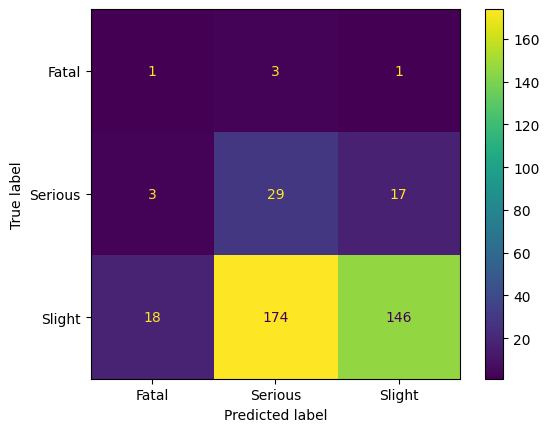

In [311]:
from sklearn import metrics

y_pred_regression = search_acc_regression.predict(X_test_transformed)
cnf_matrix_regression = metrics.confusion_matrix(y_test, y_pred_regression,
                                                 labels=search_acc_regression.classes_)
display = metrics.ConfusionMatrixDisplay(cnf_matrix_regression,
                                         display_labels=label_encoder.classes_)
display.plot()
...

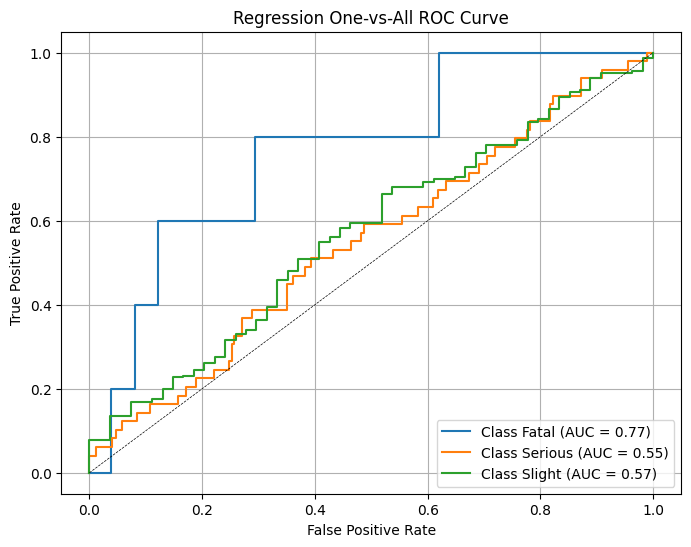

In [319]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def show_ova_roc(estimator, X_test, y_test, classes: list, name: str):
    """
    Computes "One-vs-All" (OvA) ROC curve
    
    ROC curve is constructed for each class separately by
    treating that class as the positive class and the rest as the negative class. 
    This results in multiple ROC curves, one for each class.
    :param estimator: 
    :param X_test: 
    :param y_test: 
    :param classes: 
    :param name: 
    :return: 
    """
    
    # Compute class probabilities for the test set
    y_proba = estimator.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(estimator.classes_)):
        fpr[i], tpr[i], _ = roc_curve((y_test == estimator.classes_[i]).astype(int), y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(estimator.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)  # Plot the diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} One-vs-All ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


show_ova_roc(search_acc_regression, X_test_transformed, y_test, label_encoder.classes_, "Regression")

### Random Forest

In [303]:
search_acc_forest.best_score_

0.8570471990854156

In [304]:
search_acc_forest.score(X_test_transformed, y_test)

0.8596938775510204

Ellipsis

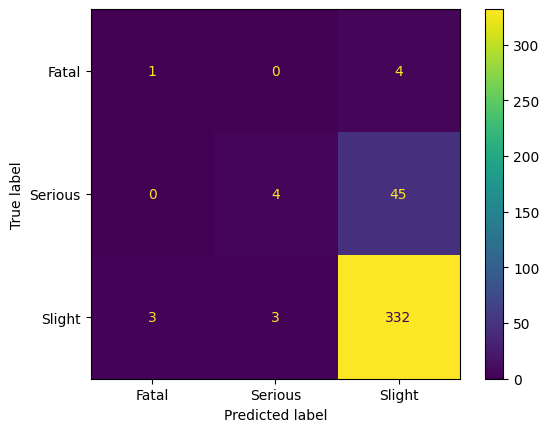

In [312]:
y_pred_forest = search_acc_forest.predict(X_test_transformed)
cnf_matrix_regression = metrics.confusion_matrix(y_test, y_pred_forest,
                                                 labels=search_acc_forest.classes_)
display = metrics.ConfusionMatrixDisplay(cnf_matrix_regression,
                                         display_labels=label_encoder.classes_)
display.plot()
...

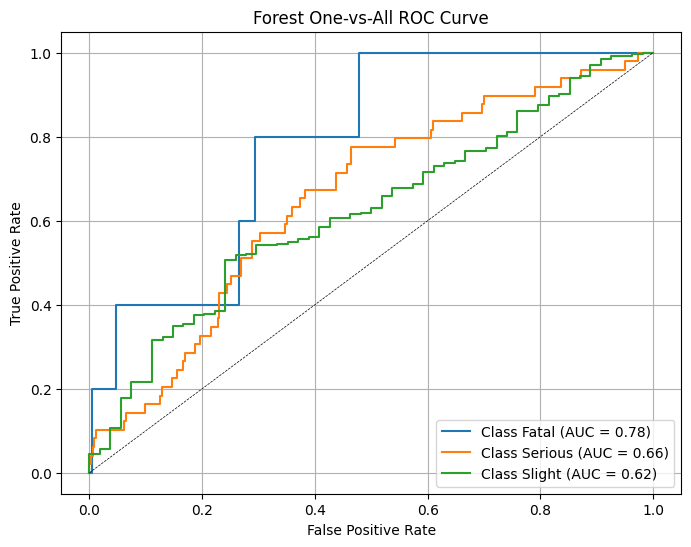

In [318]:
show_ova_roc(search_acc_forest, X_test_transformed, y_test, label_encoder.classes_, "Forest")

### Conclusion
In this course work we worked with UK Traffic Accidents data.
Our aim was to classify incident severity.

The source dataset is very large. In order to keep computation time on reasonable levels we randomly loaded 1/1000 of the dataset.
We split the data to training and testing dataset in proportion 80:20.

We preprocessed the data by:
* merging dataset with accident information and dataset witch vehicle information
* removing variations of expressing missing values in the dataset 
* removing columns where more than 40% values were missing
* creating new column with extracted hour in day from time of the accident
* creating new column with extracted day in year from date of the accident
* using pipeline to handle missing values, encode and scale variables 

Then we built modeling pipeline for Logistic Regression and RandomForest.
The the pipeline consists of:
* Feature selection with Recursive Feature Elimination based on decision tree
* Hyper-parameter tuning and cross-validation using GridSearchCV   
* Training the model

We evaluated the models on their accuracy score and visualised trained model properties using:
*  Confusion Matrix
*  One-vs-All" (OvA) ROC curve

Overall RandomForest had great accuracy of ~0.86.
Logistic Regression model had poor accuracy of ~0.45.
We conclude that the poor performance was caused by the problem complexity and partly by not equal distribution of the target class in the training and test data.  
 